# Overview
One of the most exciting and fun ideas in computer vision is style transfer, which is simply taking an original images (aka content image) and applying the artistic style of another image (style image) to create a new and visually interesting result (generated image).
We'll see how we can create a code able to perform this task, and we 'll also give you an intuition about the math empowring it.

##  Importing essential libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time

## Image processing
First step in our journey is to make some preprocessing techniques namely we must have a valid & supported input so that they can fit the neural network of interest well namely we gotta have a function for loading and another for displaying images.
The following functions are going to read the content of the image in a tensor-way so that we can use it directly through the next coming functions.
These comming functions are availabe in the Tensorflow tutorial of style-transfer: https://www.tensorflow.org/tutorials/generative/style_transfer

In [2]:
def load_img(img_path):
    #This first step gonna make us read the file and convert it into a tensor with normalized values
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels = 3) #Make sure the input image contains exaclty 3 channels
    img = tf.image.convert_image_dtype(img, tf.float32)
    #Specifying the scaling value
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    #Resizing the input image
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    #This is going to add the batch dimension
    img = img[tf.newaxis, :] #Tensor with shape = (1, height, width, channels)
    return img

Elementary function to display an image:(Optional)

In [3]:
def imshow(image, title):
    #Simple function to display an image, image here should be either a numpy array or tf tensor that can be handled by matplotlib
    image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    plt.title(title)

Let's test these two functions:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Neural-Style-Transfer/

/content/drive/MyDrive/Neural-Style-Transfer


In [6]:
!ls Content_images/

Cimage1.png  Cimage2.png


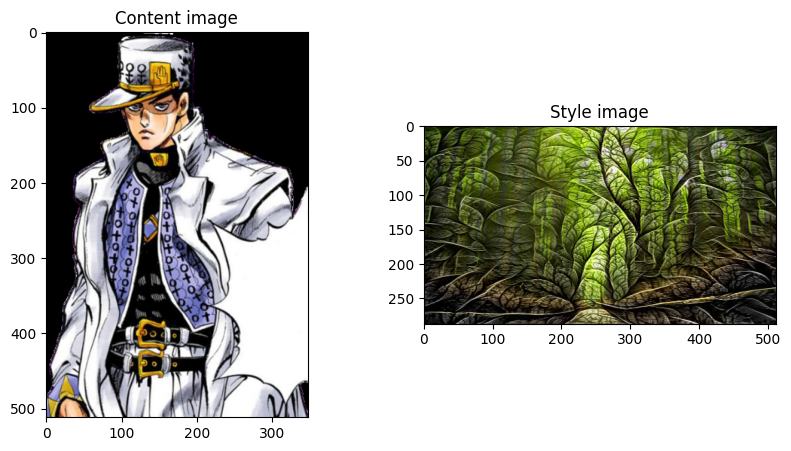

In [7]:
plt.figure(figsize=(10,5))
Cimage_path = "./Content_images/Cimage1.png"
loaded_Cimage = load_img(Cimage_path)
Simage_path = "./Style_images/Simage3.png"
loaded_Simage = load_img(Simage_path)
# Display the content image
plt.subplot(1, 2, 1)
imshow(loaded_Cimage, "Content image")
plt.subplot(1, 2, 2)
imshow(loaded_Simage, "Style image")

### Example using the tensorflow_hub
If you want to see what that means and how style will be transfered to the other image, you can try this already implemented version

In [8]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(loaded_Cimage), tf.constant(loaded_Simage))[0]

Let's create a function that will enhance the appearance of images.

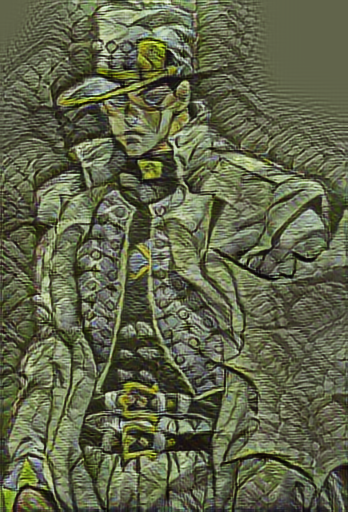

In [9]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    image = np.array(tensor, dtype = np.uint8)
    if np.ndim(image) > 3:
        #Batch of images case
        assert image.shape[0] == 1 #As shown above: tensors contain 1 image example
        image = image[0]
    return PIL.Image.fromarray(image)

tensor_to_image(stylized_image)

# Neural Style Transfer
The previous part is responsible to introduce you to this known technique in computer vision. In this section we' ll through multiple steps build our style transfer model and so we 'll be hard coding the theory behind it ourselves, we' ll also use the power of linear algebra to define new concepts such as the style matrix.
Since it's computationaly demanding building andt raining a deep neural network, with the technique we' ll see now things are going to be really straight-forward.

## Transfer learning
In the field of computer vision, transfer learning is commun useful technique aims to use a pretrained model and use it for your own task. Here's an example that illustrates the process:

![image.png](attachment:image.png)


It might be complex to understand but keep in mind that those deep and fully connected layers are responsible to full fill the task itself, so that are the layers we have to freeze in order to transfer the knowledge of another task or problem to complete your own task. For our case we're going to use VGG-19, since it has 19 layers and has been trained on a large dataset of images so its shallow layers have already learned basic features, and its deep layers have learned complex high level features and luckly that what we exactly need.

## Model building
### Load the VGG19 model

In [10]:
#This loads and freezes the vgg19 model excluding the last layers (fully connected layers at the end of the model)
vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
vgg19_model.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


### Setting the content & style layers
The meaning of this is among all the layers of the VGG19 model choose the convinient layers to put on our transfer_model.

In [11]:
for layer in vgg19_model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


#### Content layers
You see, our model contains a numerous layers. The next step is to choose those to set up to define new concepts. We' ll later see why, but in neural style transfer, the choice of content and style layers is crucial for achieving the desired balance between content preservation and transfered style.

In [12]:
#We' ll see the reason for these choices after
content_layer = [('block5_conv4', 1)]

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

### Build the model

In [13]:
def get_layer_outputs(vgg19_model, layer_names):
    outputs = [vgg19_model.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg19_model.input], outputs)
    return model

model = get_layer_outputs(vgg19_model, content_layer + STYLE_LAYERS)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Cost function
This part of the project is so far the most interesting one, in fact we'll define now the Loss function to train the model and so generate art. In addition, this section is going to contain theory behind the art we saw earlier, so we' ll try our best to simplify it in order to at least grasp the intuition behind all the formulas. At the end you' ll be able also to understand the choice of the content and style layers.

![img.png](attachment:img.png)

At first glance, the concept of neural style transfer and the formulation of the loss function might seem perplexing. This could be due to the intricacies involved in defining a loss function that effectively balances the transfer of artistic style while retaining the content of an image.
Here' s a good way to formalize a cost function: Since the purpose of style transfer is finding a balance between preserving the original content image and the artistic style of the style image, then the term of optimization might click on your mind and so you can deduce: The cost function should be capable of penalizing the model into doing the job as well as possible, and since two things at the same time should be kept (respecting the content while transfering style), then a good formalism of the cost is to contain two parts the content cost and style cost as follows:

![image.png](attachment:image.png)

With α and β are hyperparameters.

The heart of NST is to update the generated image each time model learns some new complex features and apply it to this generated image =>  here's the formula we explained now:
                                           
   ![image-2.png](attachment:image-2.png)

That' s cool isn't it!

## Content Cost function
After going in and start coding, let 's take a moment appreciate the details of it, in fact it's here where we are going to understand the choice of content layer. One aspect that 'll help in the understanding of the upcoming concepts is:
#### Depth in CNN:
Early layers in the network capture low-level features like edges and textures.

Deeper layers capture higher-level and more abstract features.

Here's what that means:

![image-2.png](attachment:image-2.png)

Keeping that on mind along with the fact that you need the "generated" image G to have similar content as the input image C implies that the choice of the content layer has to be somewhere in "the middle" to not closely mimic the content but lose the overall artistic style (shallow layers case) nor having the style dominant in the generated image and loose content => "The details of the choice we made earlier".
After making this choice, what we want is to make this hidden layer's activations  $a^{(C)}$ and $a^{(G)}$ really close. Well that's possible if you use norms from linear algebra, and hence coming with this cost function to motivate the model making $a^{(C)}$ and $a^{(G)}$ similar:

![image.png](attachment:image.png)

* Note that   $\frac{1}{4 \times n_H \times n_W \times n_C}$ is  a normalization factor: Scales the content loss to ensure that it is not overly influenced by the dimensions of the feature maps. Here $(n_H,n_W,n_C)$ represent the height, width, and number of channels of the feature maps, respectively.


Reshaping activations from a 3D volume to 2D matrices serves the purpose of facilitating computations by organizing each activation in a dedicated row. The resultant 2D matrix representation allows for a more structured and accessible format, optimizing the handling of information for subsequent layers or analytical operations.

![image-3.png](attachment:image-3.png)

Input of Most of the following functions will be the output of the model which as list.

In [14]:
def content_cost(content_image_output, generated_image_output):
    a_C = content_image_output[-1]
    a_G = generated_image_output[-1]
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    #Reshape
    a_C_unrolled = tf.reshape(a_C, shape = [1, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [1, n_H * n_W, n_C])
    #Content_Cost
    J_content = (1/(4* n_H * n_W * n_C)) * (tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))))
    return J_content

## Style Cost function

### Style meaning & formalism
In this phase, a worth asking question is what's the style of an image and how can we define it mathematically? Well to define "the style" isn't that complicated, here's an intuitive baseic definition:  Style can be interepreted as the way in which the content of an image is presented (its colors, textures, and patterns ...), in deep learning words, we can say so the style of an image has to do with computations similarity of activations across different channels(since as we saw those activations are what defines patterns ... ) Or more formaly, the correlation between those activations.

Luckily for us, a famous tool to define correlation in linear algebra is the dot product, in which a high value suggest a high correlation or similarity between the two vectors (in our case the two activations). Here's an illustration:

![image.png](attachment:image.png)

Since we have multiple activations, to tell the overall style of the image, we' ll have to compare all the activations and here this formula should appear:

![image-2.png](attachment:image-2.png)

Where $G_{ij}$ is the result of the dot product of the j-th: $v_j$ and i-th: $v_i$ activations along same layer, across different channels since channels. Which leads us to store all these "similarity-informations" in a matrix: **Style matrix**, if you' re familiar with linear algebra you' ll probably notice that yes it 's the Gram matrix, you see how powerfull is math!
Here'are two forms of the Gram matrix, a fun intuitive one, and a rigorous one:

![image-4.png](attachment:image-4.png)

![image-3.png](attachment:image-3.png)

You can also see in other literature this formula: The gram matrix of A is $G_A = AA^T$.

In [15]:
def Gram_matrix(matrix):
    G = tf.linalg.matmul(matrix, tf.transpose(matrix))
    return G

### Layer Style Cost
After we've defined the style matrix, what follows is going to be straightforward. Our job is to motivate the model to transfer the style to the generated image. So, we're basically saying we want to make two quantities similar. To iteratively encourage the model to do this, we'll use, again, like we've done for content cost, the concept of norms. This involves choosing a hidden layer ${[l]}$.

We'll see later how we're going to define the cost using a weighted sum of layer style costs. But for now, let's focus on this formula:

![image.png](attachment:image.png)

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* $\frac{1}{{4 \times n_C^2 \times (n_H \times n_W)^2}}$: This term normalizes the cost by the product of the number of channels $n_C$ and the spatial dimensions $(n_H \times n_W)$ squared.


In [16]:
def style_layer_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.reshape(a_S, [-1, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, [-1, n_C])
    a_G = tf.transpose(a_G)
    GS = Gram_matrix(a_S)
    GG = Gram_matrix(a_G)
    denominator = (.5 / (n_H * n_W * n_C)) ** 2
    J_layer_style =  denominator * (tf.reduce_sum(tf.square(tf.subtract(GS, GG))))
    return J_layer_style

### Style cost

The provided fucntion above computes how close the resulting style and generated image after being fed to the model. So as the name of the function suggests we're getting an idea about how the style and generated image at a layer L are, and again we 'll use what' s supposed to be one of the most important concepts in this notebook which is features capturing per layer, because of that we'll use different layer style costs to define the **Style cost**, in other words to define the style cost we'll use a weighted sum of the layer style costs:
![Style_cost.png](attachment:Style_cost.png)

With ${lambda^{[l]}}$ is a hyperparamter: it's the weight of the style cost at layer l.

In [17]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

The $0.2$s are the lambdas we' ll choose, feel free to change these values and see the results!

The image below has been included for the sake of simplicity and to aid in gaining intuition.

![image.png](attachment:image.png)

It does illustrutes where are the layer choosen for the style cost.

In [18]:
def Style_cost(style_output, generated_output, STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0
    a_S = style_output[:-1]
    a_G = generated_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        J_style_layer = style_layer_cost(a_S[i], a_G[i])
        J_style += J_style_layer * weight[1]
    return J_style

### Putting it All Together
We 'll use all the previous concepts we've defined and we' ll define the **Cost function** to be able to train the model and then try some awsome art generation.

The formula for the total cost a mentioned earlier:  $$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

$\alpha$ and $\beta$ are hyperparamters


In [19]:
# This allows tensorflow to build the computation graph (Runs faster than a normal python code)
@tf.function()
def cost_funtion(J_content, J_style, alpha, beta):
    J = alpha * J_content + beta * J_style
    return J

We already know the update rule: $G = G - \text{learning_rate} \cdot \frac{dJ}{dG}$

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-8)

@tf.function()
def training_step(content_image_output, style_image_output, generated_image):
    # Explicitly watch the generated_image tensor
    with tf.GradientTape() as tape:
      generated_image_output = model(generated_image)
      # Cost functions
      J_content = content_cost(content_image_output, generated_image_output)
      J_style = Style_cost(style_image_output, generated_image_output)
      J = cost_funtion(J_content, J_style, alpha=10, beta=40)
    # Optimization step
    gradient = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(gradient, generated_image)])
    # Normalization of the tensor values to ensure the speed of convergence during optimization
    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
    return J

In [29]:
def TrainStyleTransfer(content_image_output, style_image_output, generated_image, epochs):
    for i in range(epochs):
        training_step(content_image_output, style_image_output, generated_image)

#### Testing & showing  the results
Before that we need a function to generate "the generated image", to be able to then apply the training updates to this image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.

In [30]:
def initial_generated_image(content_image, seed):
    generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
    generated_image.assign_add(tf.random.normal(shape=generated_image.shape, mean=0.0, stddev=0.1))
    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
    return generated_image

Art generation!

In [31]:
def image_encoding(image_path):
    image = load_img(image_path)
    image = tf.Variable(tf.image.convert_image_dtype(image, tf.float32))
    return model(image)

Initial generated image (the random noise effect)

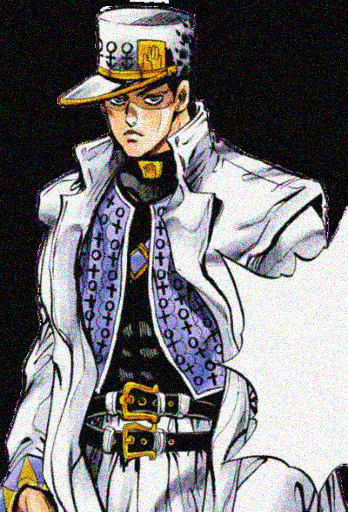

In [32]:
content_image_path = "./Content_images/Cimage1.png"
style_image_path = "./Style_images/Simage1.png"
generated_image = initial_generated_image(load_img(content_image_path), 42)
generated_image = tf.Variable(generated_image, trainable=True)
tensor_to_image(generated_image)

In [25]:
content_image_output, style_image_output = image_encoding(content_image_path), image_encoding(style_image_path)

In [33]:
TrainStyleTransfer(content_image_output, style_image_output, generated_image, 20)

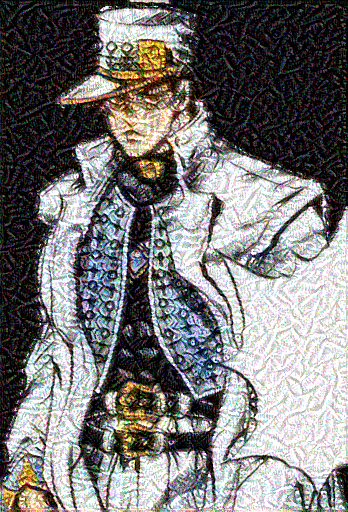

In [34]:
tensor_to_image(generated_image)